In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [ ]:
data = pd.read_csv('housing.csv')
print("Thông tin dữ liệu:")
data.info()

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
print("\nCác giá trị thiếu trong dữ liệu:")
print(data.isnull().sum())
data = data.dropna()


Các giá trị thiếu trong dữ liệu:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [ ]:
data = pd.get_dummies(data, columns=['ocean_proximity'])

In [ ]:
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
joblib.dump(lr, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

In [ ]:
ridge = Ridge()
parameters_ridge = {'alpha': [0.1, 1, 10, 100, 200]}
ridge_cv = GridSearchCV(ridge, parameters_ridge, cv=5)
ridge_cv.fit(X_train, y_train)
print("\nBest alpha for Ridge Regression:", ridge_cv.best_params_)
y_pred_ridge = ridge_cv.predict(X_test)
joblib.dump(ridge_cv.best_estimator_, 'ridge_regression_model.joblib')


Best alpha for Ridge Regression: {'alpha': 0.1}


['ridge_regression_model.joblib']

In [ ]:
mlp = MLPRegressor(
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-5
)
parameter_space_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
}
mlp_cv = GridSearchCV(mlp, parameter_space_mlp, n_jobs=-1, cv=3)
mlp_cv.fit(X_train, y_train)
print("\nBest parameters for MLP Regressor:", mlp_cv.best_params_)
y_pred_mlp = mlp_cv.predict(X_test)
joblib.dump(mlp_cv.best_estimator_, 'mlp_regressor_model.joblib')
mlp_loss_curve = mlp_cv.best_estimator_.loss_curve_


Best parameters for MLP Regressor: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
estimators = [
    ('lr', lr),
    ('ridge', ridge_cv.best_estimator_),
    ('mlp', mlp_cv.best_estimator_)
]
final_mlp = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-5,
    random_state=42
)

stacking_regressor_mlp = StackingRegressor(
    estimators=estimators,
    final_estimator=final_mlp,
    passthrough=False,
    n_jobs=-1
)
stacking_regressor_mlp.fit(X_train, y_train)
y_pred_stack_mlp = stacking_regressor_mlp.predict(X_test)
joblib.dump(stacking_regressor_mlp, 'stacking_regressor_model.joblib')
stacking_mlp_loss_curve = stacking_regressor_mlp.final_estimator_.loss_curve_


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

In [ ]:
print("\nĐánh giá mô hình:")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_mlp, "MLP Regressor with Early Stopping")
evaluate_model(y_test, y_pred_stack_mlp, "Stacking Regressor with MLP Regressor Final Estimator")


Đánh giá mô hình:
Linear Regression - MAE: 50413.43, MSE: 4802173538.60, RMSE: 69297.72
Ridge Regression - MAE: 50410.97, MSE: 4801314875.42, RMSE: 69291.52
MLP Regressor with Early Stopping - MAE: 43129.58, MSE: 3752416010.19, RMSE: 61256.97
Stacking Regressor with MLP Regressor Final Estimator - MAE: 43190.86, MSE: 3725969500.82, RMSE: 61040.72


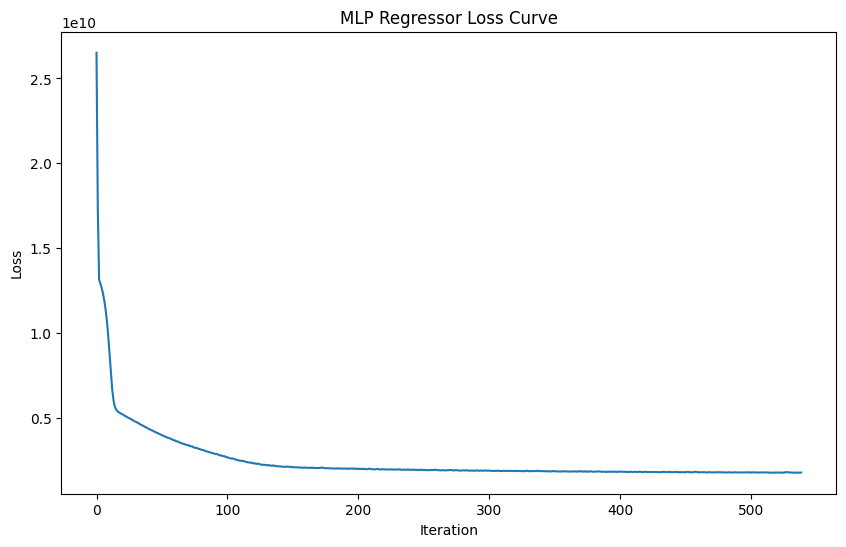

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mlp_loss_curve)
plt.title("MLP Regressor Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

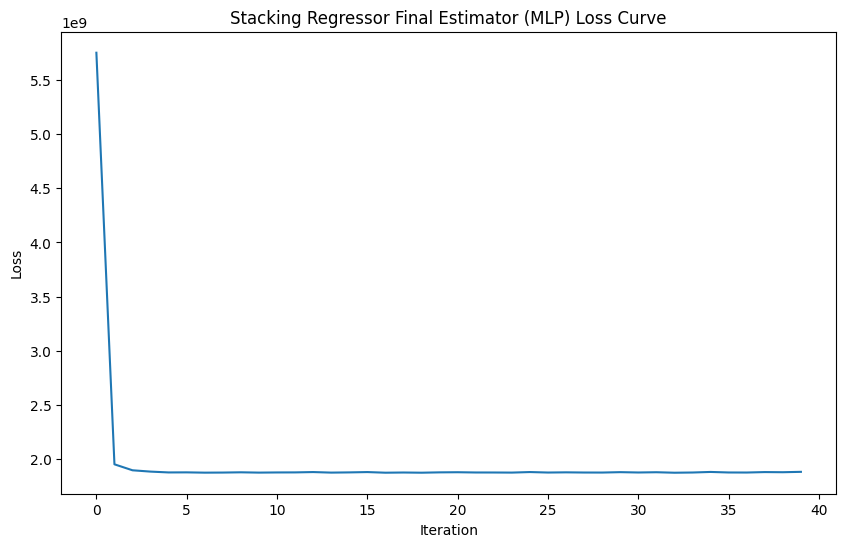

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(stacking_mlp_loss_curve)
plt.title("Stacking Regressor Final Estimator (MLP) Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

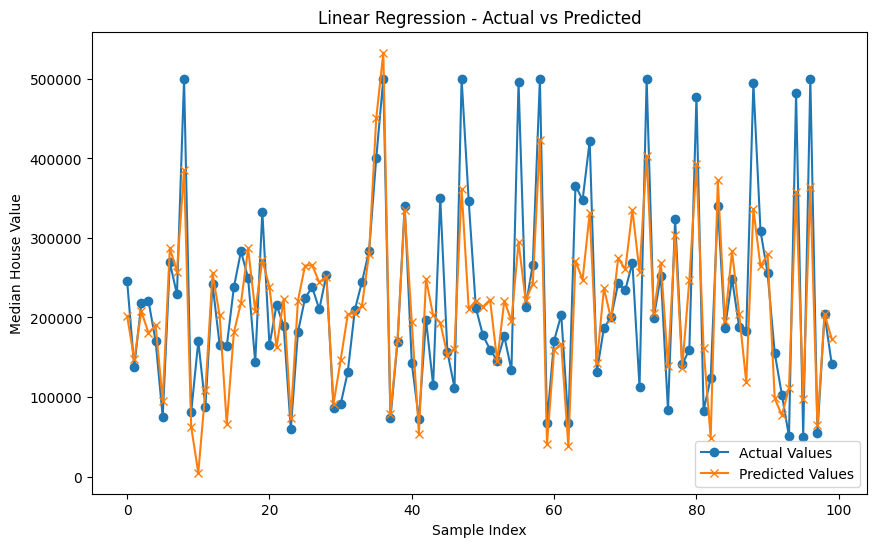

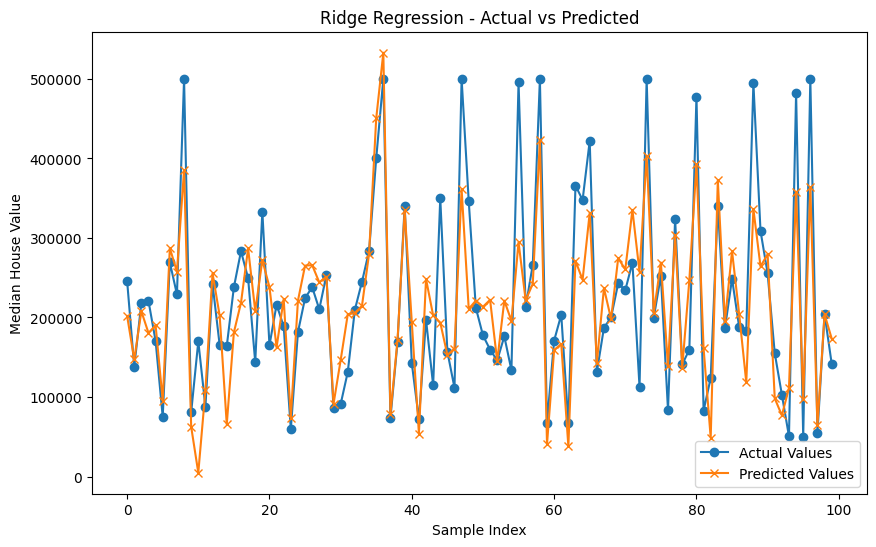

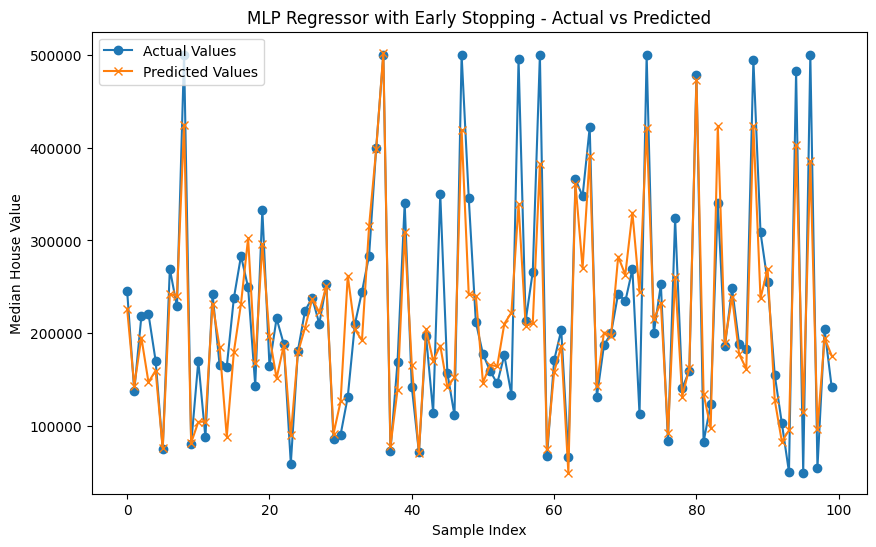

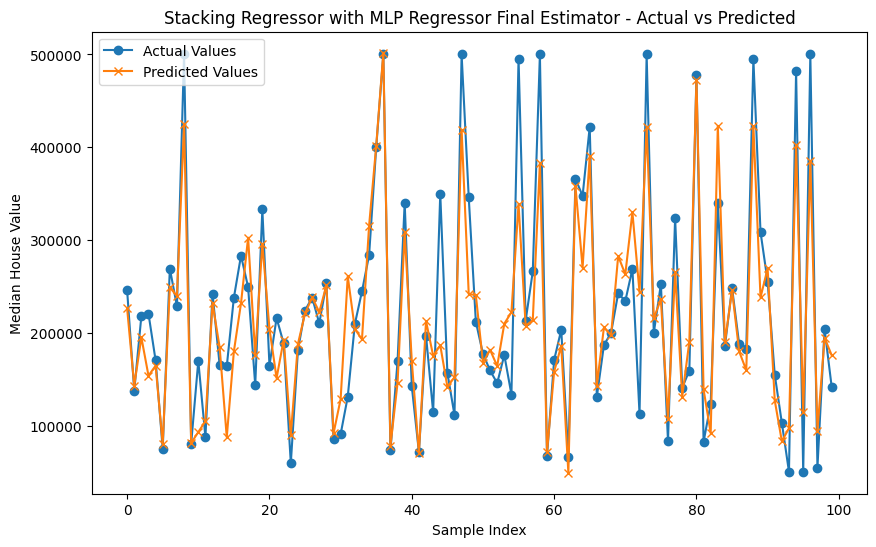

In [ ]:
models = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'MLP Regressor with Early Stopping': y_pred_mlp,
    'Stacking Regressor with MLP Regressor Final Estimator': y_pred_stack_mlp
}
for model_name, y_pred in models.items():
    plt.figure(figsize=(10,6))
    plt.plot(y_test.values[:100], label='Actual Values', marker='o')
    plt.plot(y_pred[:100], label='Predicted Values', marker='x')
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel('Sample Index')
    plt.ylabel('Median House Value')
    plt.legend()
    plt.show()